# Stage 2: Advanced Embedding Models Training and Analysis
### Team 7: Nicole Bolliger, Vitalia Vedenikova

## 1. Data Preparation for Embeddings

### 1.1. Libraries and loading Dataset

In [ ]:
!pip install langdetect
!pip install pyspellchecker
!pip install unidecode
!pip install num2words
!pip install contractions
!pip install sentence-transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=6b2e641e4aba04787264305878018db869dbfb73bad4e6ba76e87091a3978d25
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 8.1 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=7364b1ddece5836218299ad80f28fcd7584e057d8b866e8e120146c704656954
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
   ━━━━━━━━━━━━

In [ ]:
import pandas as pd
import json
import re
import spacy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import string
import re
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from spacy.lang.en import English
from langdetect import detect, detect_langs, DetectorFactory
from spellchecker import SpellChecker
from collections import Counter
from gensim.models import Word2Vec
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

from gensim.utils import tokenize
from gensim.parsing.preprocessing import remove_stopwords

import nltk
import unidecode
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from collections import defaultdict

from bs4 import BeautifulSoup
import string
from num2words import num2words
import contractions

try:
    nltk.data.find('taggers/averaged_perceptron_tagger_eng/')
except LookupError:
    nltk.download('averaged_perceptron_tagger_eng')

nltk.download('wordnet')
nltk.download('punkt_tab')

pd.set_option('display.max_colwidth', None)


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -q $zip_path -d /content/project_dataset

Mounted at /content/drive
UnZip 6.00 of 20 April 2009, by Debian. Original by Info-ZIP.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
  file[.zip] may be a wildcard.  -Z => ZipInfo mode ("unzip -Z" for usage).

  -p  extract files to pipe, no messages     -l  list files (short format)
  -f  freshen existing files, create none    -t  test compressed archive data
  -u  update files, create if necessary      -z  display archive comment only
  -v  list verbosely/show version info       -T  timestamp archive to latest
  -x  exclude files that follow (in xlist)   -d  extract files into exdir
modifiers:
  -n  never overwrite existing files         -q  quiet mode (-qq => quieter)
  -o  overwrite files WITHOUT prompting      -a  auto-convert any text files
  -j  junk paths (do not make directories)   -aa treat ALL files as text
  -U  use escapes for all non-ASCII Unicode  -UU ignore an

In [ ]:
#-----TO DELETE THIS CELL
from google.colab import drive
drive.mount('/content/drive')
!pwd
!ls '/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/'
#Import csv data into dataframes
media_df = pd.read_csv('drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/cleantech_media_dataset_v3_2024-10-28.csv')
patent_json = []  # Initialize patent_json outside the try-except block

file_path = '/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/CleanTech_22-24_updated.json'

with open(file_path) as f:
    try:
        # Try loading the entire file as a single JSON object
        patent_json = json.load(f)
    except json.JSONDecodeError:
        # If loading as a single JSON object fails
        f.seek(0)  # Reset the file pointer to the beginning

        # Iterate through each line in the file
        for line in f:
            try:
                # Attempt to parse each line as a JSON object
                data = json.loads(line)
                # Append the parsed JSON object to patent_json list
                patent_json.append(data)
            except json.JSONDecodeError as e:
                # If a line is not valid JSON, print an error message
                print(f"Skipping invalid line: {line.strip()} - Error: {e}")

# Convert dictionary to JSON string
json_string = json.dumps(patent_json)

# Convert nested JSON data to Pandas DataFrame
patent_df = pd.read_json(json_string, orient='records')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
CleanTech_22-24_updated.json		   df_patent_v2.csv  patent_test.csv
cleantech_media_dataset_v3_2024-10-28.csv  media_test.csv    patent_train.csv
df_media_v2.csv				   media_train.csv   project_dataset.zip


<ipython-input-8-a5fe056b53d1>:35: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  patent_df = pd.read_json(json_string, orient='records')


In [ ]:
zip_path = '/content/drive/My\ Drive/CLTC_Project/content/project_dataset.zip'

# Unzip the file
!unzip -q $zip_path -d /content/project_dataset


In [ ]:
#Import csv data into dataframes
media_df = pd.read_csv('/content/project_dataset/project_dataset/cleantech_media_dataset_v3_2024-10-28.csv')

In [ ]:
patent_json = []  # Initialize patent_json outside the try-except block

file_path = '/content/drive/My Drive/CLTC_Project/content/CleanTech_22-24_updated.json'

with open(file_path) as f:
    try:
        # Try loading the entire file as a single JSON object
        patent_json = json.load(f)
    except json.JSONDecodeError:
        # If loading as a single JSON object fails
        f.seek(0)  # Reset the file pointer to the beginning

        # Iterate through each line in the file
        for line in f:
            try:
                # Attempt to parse each line as a JSON object
                data = json.loads(line)
                # Append the parsed JSON object to patent_json list
                patent_json.append(data)
            except json.JSONDecodeError as e:
                # If a line is not valid JSON, print an error message
                print(f"Skipping invalid line: {line.strip()} - Error: {e}")

# Convert dictionary to JSON string
json_string = json.dumps(patent_json)

# Convert nested JSON data to Pandas DataFrame
patent_df = pd.read_json(json_string, orient='records')

<ipython-input-12-326d6695175e>:28: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  patent_df = pd.read_json(json_string, orient='records')


### 1.2. Data Cleaning and Preperation

As the cleaning has already been conducted in stage 1, we take over the cleaning step from Stage 1 for both data sets. In the Data Preperation we only need to tockenize the data.

#### Media Dataset:

In [ ]:
media_df.head(1)

,Unnamed: 0,title,date,author,content,domain,url
0,93320,"XPeng Delivered ~100,000 Vehicles In 2021",2022-01-02,NaN,"['Chinese automotive startup XPeng has shown one of the most dramatic auto production ramp-ups in history, and the good news is it only produces 100% smart electric vehicles ( EVs). At a mere 7 years of age, and just a few years after launching its first vehicle ( the XPeng G3 went on sales in December 2018), XPeng has wrapped up a year of sales totaling almost 100,000. In 2021, XPeng delivered 98,155 smart EVs, a 263% year-over-year increase.', 'In December, 16,000 vehicles were delivered, a 181% year-over-year increase compared to December 2020. There were 41,751 vehicles delivered in Q4 2021, which was a 222% year-over-year increase.', 'Reinforcing how impressive the 98,155 delivery figure for 2021 is, at the end of the year, XPeng reached just 137,953 cumulative deliveries.', 'All the more impressive, XPeng’ s monthly delivery target is 15,000 vehicles, and December was the second month in a row that was surpassed — and that’ s despite the global automotive chip shortage and other supply chain challenges.', 'In the case of the P7, deliveries were up 102%. GS deliveries were up 75%. The P5 was not on the market one year ago, but its sales did increase 134% month over month.', 'XPeng also noted that its broader charging and sales network in China has been growing “ rapidly. ” It had “ 661 branded supercharging stations across 228 cities and 311 physical retail stores in operation across 121 cities as of the end of November 2021. ”', 'All in all, XPeng’ s growth seems to be rolling out as the company hoped and planned, or even better. It’ s quite an uplifting sight to see another pure EV company scaling up production rapidly and achieving great sales success at a young age. Of course, the reference company need not be named, and we need not compare the two or pretend XPeng should exactly follow Tesla’ s ( whoops) path. However, the point is that we are getting more examples of pure EV companies achieving great successes.', ""Zach is tryin ' to help society help itself one word at a time. He spends most of his time here on CleanTechnica as its director, chief editor, and CEO. Zach is recognized globally as an electric vehicle, solar energy, and energy storage expert. He has presented about cleantech at conferences in India, the UAE, Ukraine, Poland, Germany, the Netherlands, the USA, Canada, and Curaçao. Zach has long-term investments in Tesla [ TSLA ], NIO [ NIO ], Xpeng [ XPEV ], Ford [ F ], ChargePoint [ CHPT ], Amazon [ AMZN ], Piedmont Lithium [ PLL ], Lithium Americas [ LAC ], Albemarle Corporation [ ALB ], Nouveau Monde Graphite [ NMGRF ], Talon Metals [ TLOFF ], Arclight Clean Transition Corp [ ACTC ], and Starbucks [ SBUX ]. But he does not offer ( explicitly or implicitly) investment advice of any sort."", 'Advertise with CleanTechnica to get your company in front of millions of monthly readers.', 'Rethink Energy has made the prediction that some countries’ entire automotive fleets will be electric within the next decade. Policy changes in various countries...', 'Tesla hits the UK with its strongest ever May, helping lift the plugin electric vehicle market share to 23.1%, up from 18.3% year on...', 'The auto market in Germany saw plugin EVs take 22.9% share in May 2023, down from 25.3% year on year. Full electrics gained share,...', 'Recently, we did a story about the 2023 NADA convention and goat roping in Dallas, where Slate correspondent Alexander Sammon got a chance to...', 'Copyright © 2023 CleanTechnica. The content produced by this site is for entertainment purposes only. Opinions and comments published on this site may not be sanctioned by and do not necessarily represent the views of CleanTechnica, its owners, sponsors, affiliates, or subsidiaries.']",cleantechnica,https://cleantechnica.com/2022/01/02/xpeng-delivered-100000-vehicles-in-2021/


In [ ]:
# The author column is empty
unique_authors = media_df['author'].unique()
unique_authors

array([nan])

In [ ]:
# remove author and unnamed column
media_df = media_df.drop(['author','Unnamed: 0'], axis= 1)

In [ ]:
# check for duplicates
num_duplicates = media_df.duplicated().sum()
print(f"Number of duplicates: {num_duplicates}")

Number of duplicates: 0


In [ ]:
## Correct Data Type

#The title and content are both object data types
media_df[['content', 'title']].dtypes

,0
content,object
title,object


In [ ]:
# We cast them as string data types
columns_to_cast = ['content', 'title']

for column in columns_to_cast:
    media_df[column] = media_df[column].astype('string')

media_df[['content', 'title']].dtypes

,0
content,string[python]
title,string[python]


In [ ]:
# We remove all content not in english
print(f"The current amount of articles is : {len(media_df)}")
detected_languages = [detect_langs(text) for text in media_df['content'].astype(str)]
media_df['detected_language'] = detected_languages

DetectorFactory.seed = 0

flattened_languages = [lang.lang[:2] if lang else 'unknown' for sublist in detected_languages for lang in sublist]

counts = Counter(flattened_languages)

language_stats = pd.DataFrame.from_dict(counts, orient='index', columns=['Count'])
en_count = language_stats.loc[language_stats.index.str.startswith('en', na=False), 'Count'].sum()
print(f"Number of times 'en' appears: {en_count}")

media_df['is_en'] = media_df['detected_language'].apply(lambda langs: any(lang.lang.startswith('en') for lang in langs))
media_df = media_df[media_df['is_en']]
print(f"The amount of articles now is: {len(media_df)}")

media_df = media_df.drop(['detected_language','is_en'], axis= 1)

The current amount of articles is : 20111
Number of times 'en' appears: 20108
The amount of articles now is: 20108


In [ ]:
# Lowercasing both the content and the title (the latter might be used for EDA)
media_df['content'] = media_df['content'].str.lower()
media_df['title'] = media_df['title'].str.lower()

In [ ]:
# remove punctuation
PUNCTUATIONS = string.punctuation

def remove_punctuation(df, section):
  df[f'{section}'] = df[f'{section}'].apply(lambda x: x.translate(str.maketrans('', '', PUNCTUATIONS)))
  return df

media_df = remove_punctuation(media_df, 'content')
media_df = remove_punctuation(media_df, 'title')


"\n# remove punctuation\nPUNCTUATIONS = string.punctuation\n\ndef remove_punctuation(df, section):\n  df[f'{section}'] = df[f'{section}'].apply(lambda x: x.translate(str.maketrans('', '', PUNCTUATIONS)))\n  return df\n\nmedia_df = remove_punctuation(media_df, 'content')\nmedia_df = remove_punctuation(media_df, 'title')\n"

In [ ]:
# remove quotation marks and dashes
def remove_quotes_dashes(text):
  """Removes quotation marks and dashes"""
  text = re.sub(r'[\"\'\u201D\u201C]', '', text)  # Remove quotation marks
  text = re.sub(r'[\u2013\u2014\u2015]', ' ', text)  # Remove dashes
  return text

media_df['content'] = media_df['content'].apply(remove_quotes_dashes)

In [ ]:
# remove emails, URLs and HTML tags
# Remove emails
media_df['content'] = media_df['content'].astype(str)

#Emails without spaces between username and domain name:
media_df['content'] = media_df['content'].apply(lambda x: re.sub(r'\S+@\S+', '', x))

#Emails with spaces between username and domain name:
media_df['content'] = media_df['content'].apply(lambda x: re.sub(r'[\w\.-]+(?:\s+)?@(?:\s+)?[\w\.-]+(?:\.[\w\.-]+)+', '', x))

In [ ]:
# Remove URLs
media_df['content'] = media_df['content'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x))

In [ ]:
# Remove HTML tags
def remove_html(df, section):
    df[f'{section}'] = df[f'{section}'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
    return df

media_df = remove_html(media_df, 'content')

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

media_df['content'] = media_df['content'].apply(lambda x: remove_emoji(x))

In [ ]:
# removing copyright information
def remove_text_after_copyright(text):
  match = re.search(r"(©|copyright ©).*", text)
  if match:
    return text[:match.start()]
  return text

media_df['content'] = media_df['content'].apply(remove_text_after_copyright)

In [ ]:
media_df["domain"].unique()

array(['cleantechnica', 'pv-magazine', 'naturalgasintel', 'energyvoice',
       'solarpowerworldonline', 'solarindustrymag', 'thinkgeoenergy',
       'energy-xprt', 'azocleantech', 'pv-tech', 'rechargenews',
       'solarpowerportal.co', 'energyintel', 'greenprophet', 'ecofriend',
       'eurosolar', 'greenairnews', 'all-energy', 'iea', 'decarbxpo',
       'biofuels-news', 'solarquarter', 'storagesummit', 'indorenergy',
       'bex-asia'], dtype=object)

In [ ]:
def remove_text_after_certain_string(text, search_string):
  """Removes text after a specific string from a given text."""
  match = re.search(rf"({search_string}).*", text)
  if match:
    return text[:match.start()]
  return text

def remove_text_between_phrases(text, phrase_1, phrase_2):
  """Removes text between two given phrases."""
  phrase_1 = re.escape(phrase_1)
  phrase_2 = re.escape(phrase_2)
  pattern = rf"{phrase_1}.*?{phrase_2}"
  cleaned_text = re.sub(pattern, "", text, flags=re.DOTALL)
  return cleaned_text

# For pv-magazine
search_string = "this content is protected by copyright and may not be reused"
for index, row in media_df[media_df["domain"] == "pv-magazine"].iterrows():
    media_df.loc[index, 'content'] = remove_text_after_certain_string(row['content'], search_string)

# For naturalgasintel
phrase_1 = "sign in to get the best natural gas news"
phrase_2 = "ngi all news access"
for index, row in media_df[media_df["domain"] == "naturalgasintel"].iterrows():
    media_df.loc[index, 'content'] = remove_text_between_phrases(row['content'], phrase_1, phrase_2)

# For solarindustrymag
phrase_1 = "solar industry offers"
phrase_2 = "stay current and navigate the solar market"
for index, row in media_df[media_df["domain"] == "solarindustrymag"].iterrows():
    media_df.loc[index, 'content'] = remove_text_between_phrases(row['content'], phrase_1, phrase_2)

# For energy-xprt
phrase_1 = "no comments"
phrase_2 = "first to comment"
for index, row in media_df[media_df["domain"] == "energy-xprt"].iterrows():
    media_df.loc[index, 'content'] = remove_text_between_phrases(row['content'], phrase_1, phrase_2)

search_string = "energy xprt is a global|need help finding the right suppliers"
for index, row in media_df[media_df["domain"] == "energy-xprt"].iterrows():
    media_df.loc[index, 'content'] = remove_text_after_certain_string(row['content'], search_string)

# For azocleantech
search_string = "hi i m azthena you can trust"
for index, row in media_df[media_df["domain"] == "azocleantech"].iterrows():
    media_df.loc[index, 'content'] = remove_text_after_certain_string(row['content'], search_string)

# For rechargenews
search_string = "recharge is part of dn media group"
for index, row in media_df[media_df["domain"] == "rechargenews"].iterrows():
    media_df.loc[index, 'content'] = remove_text_after_certain_string(row['content'], search_string)

#For solarpowerportal.co
search_string = "thank you for subscribing"
for index, row in media_df[media_df["domain"] == "solarpowerportal.co"].iterrows():
    media_df.loc[index, 'content'] = remove_text_after_certain_string(row['content'], search_string)

#For greenprophet
phrase_1 = "windowdojorequire"
phrase_2 = "uniquemethods true"
for index, row in media_df[media_df["domain"] == "greenprophet"].iterrows():
    media_df.loc[index, 'content'] = remove_text_between_phrases(row['content'], phrase_1, phrase_2)

#For ecofriend
search_string = "ecofriendcom a dr prem guides"
for index, row in media_df[media_df["domain"] == "ecofriend"].iterrows():
    media_df.loc[index, 'content'] = remove_text_after_certain_string(row['content'], search_string)

#For eurosolar
search_string = "europäische vereinigung"
for index, row in media_df[media_df["domain"] == "eurosolar"].iterrows():
    media_df.loc[index, 'content'] = remove_text_after_certain_string(row['content'], search_string)

search_string = "independent of political parties"
for index, row in media_df[media_df["domain"] == "eurosolar"].iterrows():
    media_df.loc[index, 'content'] = remove_text_after_certain_string(row['content'], search_string)

#For greenairnews
search_string = "sustainability in the air is the first podcast"
for index, row in media_df[media_df["domain"] == "greenairnews"].iterrows():
    media_df.loc[index, 'content'] = remove_text_after_certain_string(row['content'], search_string)

#For all-energy
search_string = "your email address will not be published"
for index, row in media_df[media_df["domain"] == "all-energy"].iterrows():
    media_df.loc[index, 'content'] = remove_text_after_certain_string(row['content'], search_string)

#For iea
search_string = "get updates on the iea’ s latest news"
for index, row in media_df[media_df["domain"] == "iea"].iterrows():
    media_df.loc[index, 'content'] = remove_text_after_certain_string(row['content'], search_string)

phrase_1 = "create a free iea account"
phrase_2 = "to a paid service"
for index, row in media_df[media_df["domain"] == "iea"].iterrows():
    media_df.loc[index, 'content'] = remove_text_between_phrases(row['content'], phrase_1, phrase_2)

#For decarbxpo
search_string = "to use the full function of this web site"
for index, row in media_df[media_df["domain"] == "decarbxpo"].iterrows():
    media_df.loc[index, 'content'] = remove_text_after_certain_string(row['content'], search_string)

#For biofuels-news
search_string = "it's the leading magazine covering all"
for index, row in media_df[media_df["domain"] == "biofuels-news"].iterrows():
    media_df.loc[index, 'content'] = remove_text_after_certain_string(row['content'], search_string)

#For solarquarter
search_string = "this site uses akismet"
for index, row in media_df[media_df["domain"] == "solarquarter"].iterrows():
    media_df.loc[index, 'content'] = remove_text_after_certain_string(row['content'], search_string)


In [ ]:
def replace_symbols(text, symbol_map):
  for symbol, replacement in symbol_map.items():
    text = text.replace(symbol, replacement)
  return text

symbol_mapping = {
       '$': 'dollar ',
       '~': 'approximately',
       '%': ' percent',
       '£': 'pound ',
       '€': 'euro ',
       '₹': 'rupee ',
       '¥': ' yen',
       'gw': ' gigawatt',
       'mw': ' megawatt',
       'kw': ' kilowatt',
       'm2': ' square meter',
       'kg': ' kilogram',
       'm3': ' cubic meter',
       '°f': ' degree fahrenheit',
       '°c': ' degree celsius',
       '°k': ' degree kelvin',
       'year': ' year',
       '...' : ' ',
       'rmb' : 'renminbi ',
       'gwdc': ' gigawatts-direct current',
       'mwp' : ' megawatt peak',
       'mwh' : 'megawatt-hour',
       'gwh': ' gigawatt-hour',
       'degree': ' degree',
       'hz': ' hertz'
   }

media_df['content'] = media_df['content'].apply(lambda x: replace_symbols(x, symbol_mapping))
media_df['title'] = media_df['title'].apply(lambda x: replace_symbols(x, symbol_mapping))

In [ ]:
def remove_whitespaces(text):
  return " ".join(text.split())

media_df['content'] = media_df['content'].apply(remove_whitespaces)

In [ ]:
# Remove stopwords using gensim (default ones as well as additional stopwords we noticed in the dataset)

custom_stop_words = {"www", "http", "https", "br", "amazon", "href", "wa", "ha", "like", "just"}

def remove_stopwords_with_custom(text):
    text = remove_stopwords(text)  # Remove default stop words
    text = " ".join(word for word in text.split() if word not in custom_stop_words) # Remove custom stop words
    return text

media_df['content'] = media_df['content'].apply(remove_stopwords_with_custom)

# Print the lengths of the filtered columns and the first few rows to check the result
print(len(media_df['content']), media_df['content'].head())

20108 0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [ ]:
## Replace numbers by words
# Remove superscript characters
media_df['content'] = media_df['content'].apply(lambda x: re.sub(r"[\u00B9\u00B2\u00B3\u2018\u2019\u201A\u201B\u2032\u2033\u2034\u2035]", '', x))

In [ ]:
# Now replace numbers with words
def replace_numbers_with_words (df, column_name):
  for index, row in df.iterrows():
    text = row[column_name]
    new_text = []
    for word in text.split():
        if word.isdigit() and word.isnumeric():
            new_text.append(num2words(word))
        else:
            new_text.append(word)
    df.loc[index, column_name] = " ".join(new_text)
  return df

media_df = replace_numbers_with_words(media_df, 'content')
media_df = replace_numbers_with_words(media_df, 'title')

In [ ]:
# expanding contractions
def expand_contractions(text):
  return contractions.fix(text)

media_df['content'] = media_df['content'].apply(expand_contractions)

In [ ]:
def accented_to_ascii(text):
    return unidecode.unidecode(text)
media_df['content'] = media_df['content'].apply(accented_to_ascii)

### Patent Dataset:

In [ ]:
# Examine google patent dataframe
patent_df.head(1)

,publication_number,application_number,country_code,title,abstract,publication_date,inventor,cpc_code
0,CN-117138249-A,CN-202311356270-A,CN,一种石墨烯光疗面罩,"The application provides a graphene phototherapy mask, and relates to the technical field of phototherapy devices of graphene phototherapy masks. The solar energy heat conducting mask comprises a mask outer shell, a lamp panel, a graphene heating plate and a transparent heat conducting mask inner shell which are sequentially arranged from outside to inside; a plurality of lamp beads are arranged on the lamp panel; a plurality of through holes are formed in the graphene heating plate at positions corresponding to the lamp beads; a controller provided with a control board therein; the control panel is provided with a PWM micro-pulse control circuit and a heating control circuit, the PWM micro-pulse control circuit is electrically connected to the lamp panel and used for driving the lamp beads to emit micro-pulse light, the heating control circuit is electrically connected to the graphene heating plate and used for driving the graphene heating plate to heat, and the pulse frequency of the micro-pulse light is greater than or equal to 50Hz. The graphene phototherapy mask is driven by the heating function and the micropulse light, so that the phototherapy effect can be improved, the skin problem is improved, the use experience is improved, and better phototherapy effect and comfort are brought to users.",20231201,"[LI HAITAO, CAO WENQIANG]",A61N2005/0654


In [ ]:
## Remove duplicate rows
patent_df.duplicated(subset=['publication_number']).sum()

375491

In [ ]:
patent_df[patent_df['publication_number']=='CN-117138249-A']

,publication_number,application_number,country_code,title,abstract,publication_date,inventor,cpc_code
0,CN-117138249-A,CN-202311356270-A,CN,一种石墨烯光疗面罩,"The application provides a graphene phototherapy mask, and relates to the technical field of phototherapy devices of graphene phototherapy masks. The solar energy heat conducting mask comprises a mask outer shell, a lamp panel, a graphene heating plate and a transparent heat conducting mask inner shell which are sequentially arranged from outside to inside; a plurality of lamp beads are arranged on the lamp panel; a plurality of through holes are formed in the graphene heating plate at positions corresponding to the lamp beads; a controller provided with a control board therein; the control panel is provided with a PWM micro-pulse control circuit and a heating control circuit, the PWM micro-pulse control circuit is electrically connected to the lamp panel and used for driving the lamp beads to emit micro-pulse light, the heating control circuit is electrically connected to the graphene heating plate and used for driving the graphene heating plate to heat, and the pulse frequency of the micro-pulse light is greater than or equal to 50Hz. The graphene phototherapy mask is driven by the heating function and the micropulse light, so that the phototherapy effect can be improved, the skin problem is improved, the use experience is improved, and better phototherapy effect and comfort are brought to users.",20231201,"[LI HAITAO, CAO WENQIANG]",A61N2005/0654
58,CN-117138249-A,CN-202311356270-A,CN,Graphene phototherapy mask,"The application provides a graphene phototherapy mask, and relates to the technical field of phototherapy devices of graphene phototherapy masks. The solar energy heat conducting mask comprises a mask outer shell, a lamp panel, a graphene heating plate and a transparent heat conducting mask inner shell which are sequentially arranged from outside to inside; a plurality of lamp beads are arranged on the lamp panel; a plurality of through holes are formed in the graphene heating plate at positions corresponding to the lamp beads; a controller provided with a control board therein; the control panel is provided with a PWM micro-pulse control circuit and a heating control circuit, the PWM micro-pulse control circuit is electrically connected to the lamp panel and used for driving the lamp beads to emit micro-pulse light, the heating control circuit is electrically connected to the graphene heating plate and used for driving the graphene heating plate to heat, and the pulse frequency of the micro-pulse light is greater than or equal to 50Hz. The graphene phototherapy mask is driven by the heating function and the micropulse light, so that the phototherapy effect can be improved, the skin problem is improved, the use experience is improved, and better phototherapy effect and comfort are brought to users.",20231201,"[LI HAITAO, CAO WENQIANG]",A61N2005/0626
323,CN-117138249-A,CN-202311356270-A,CN,一种石墨烯光疗面罩,"The application provides a graphene phototherapy mask, and relates to the technical field of phototherapy devices of graphene phototherapy masks. The solar energy heat conducting mask comprises a mask outer shell, a lamp panel, a graphene heating plate and a transparent heat conducting mask inner shell which are sequentially arranged from outside to inside; a plurality of lamp beads are arranged on the lamp panel; a plurality of through holes are formed in the graphene heating plate at positions corresponding to the lamp beads; a controller provided with a control board therein; the control panel is provided with a PWM micro-pulse control circuit and a heating control circuit, the PWM micro-pulse control circuit is electrically connected to the lamp panel and used for driving the lamp beads to emit micro-pulse light, the heating control circuit is electrically connected to the graphene heating plate and used for driving the graphene heating plate to heat, and the pulse fre

In [ ]:
patent_df = patent_df.groupby('publication_number', as_index=False).agg({
    'application_number': 'first',  # Keep the first application number
    'country_code': 'first',        # Keep the first country code
    'title': 'first',     # Keep the first title
    'abstract': 'first',  # Keep the first abstract
    'publication_date': 'first',    # Keep the first publication date
    'inventor': 'first',           # Keep the first inventor
    'cpc_code': lambda x: ', '.join(x.astype(str))  # Concatenate 'cpc' values
})

In [ ]:
## remove application number
patent_df = patent_df.drop('application_number', axis= 1)

In [ ]:
## Correct Data Types:

#The publication date is an integer
patent_df['publication_date'].dtype

dtype('int64')

In [ ]:
# correct it to a date
patent_df['publication_date'] = pd.to_datetime(patent_df['publication_date'], format='%Y%m%d')

In [ ]:
# We cast the following as string data types:
columns_to_cast = ['abstract', 'title', 'inventor']

for column in columns_to_cast:
    patent_df[column] = patent_df[column].astype('string')

patent_df[['abstract', 'title','inventor']].dtypes

,0
abstract,string[python]
title,string[python]
inventor,string[python]


In [ ]:
## Only keeping the English abstract data

len(patent_df)

31366

In [ ]:
# We check if all the abstracts are in english
detected_languages = [detect_langs(text) for text in patent_df['abstract'].astype(str)]
patent_df['detected_language'] = detected_languages

DetectorFactory.seed = 0

flattened_languages = [lang.lang[:2] if lang else 'unknown' for sublist in detected_languages for lang in sublist]

counts = Counter(flattened_languages)

language_stats = pd.DataFrame.from_dict(counts, orient='index', columns=['Count'])
en_count = language_stats.loc[language_stats.index.str.startswith('en', na=False), 'Count'].sum()
print(f"Number of times 'en' appears: {en_count}")

Number of times 'en' appears: 28881


In [ ]:
# All languages that are not "en":
filtered_df = patent_df[~patent_df['detected_language'].astype(str).str.contains('en')]

#All unique language codes
filtered_df['language_code'] = filtered_df['detected_language'].apply(lambda langs: [lang.lang[:2] for lang in langs if lang])
unique_language_codes = filtered_df['language_code'][:2].explode().unique()
print(unique_language_codes)

['fr']


<ipython-input-61-c15b46379d73>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['language_code'] = filtered_df['detected_language'].apply(lambda langs: [lang.lang[:2] for lang in langs if lang])


In [ ]:
# We keep only the rows where the abstracts are in English (28'881 out of 31'366 records)
patent_df['is_en'] = patent_df['detected_language'].apply(lambda langs: any(lang.lang.startswith('en') for lang in langs))
patent_df = patent_df[patent_df['is_en']]
len(patent_df)

28881

In [ ]:
## Cleaning of inventor column

def clean_inventor_names(name_string):
  cleaned_string = re.sub(r"[\[\]']", "", name_string)
  return cleaned_string

patent_df['inventor'] = patent_df['inventor'].apply(clean_inventor_names)

In [ ]:
## Lowercasing
patent_df['abstract'] = patent_df['abstract'].str.lower()
patent_df['title'] = patent_df['title'].str.lower()

In [ ]:
PUNCTUATIONS = string.punctuation

def remove_punctuation(df, section):
  df[f'{section}'] = df[f'{section}'].apply(lambda x: x.translate(str.maketrans('', '', PUNCTUATIONS)))
  return df

patent_df = remove_punctuation(patent_df, 'abstract')
patent_df = remove_punctuation(patent_df, 'title')

In [ ]:
symbol_mapping = {
       '%': ' percent',
       'gw': ' gigawatt',
       'mw': ' megawatt',
       'kw': ' kilowatt',
       'm2': ' square meter',
       'kg': ' kilogram',
       'm3': ' cubic meter',
       '°f': ' degree fahrenheit',
       '°c': ' degree celsius',
       '°k': ' degree kelvin',
       'gwdc': ' gigawatts-direct current',
       'mwp' : ' megawatt peak',
       'mwh' : 'megawatt-hour',
       'gwh': ' gigawatt-hour',
       'hz': ' hertz'
   }

patent_df['abstract'] = patent_df['abstract'].apply(lambda x: replace_symbols(x, symbol_mapping))
patent_df['title'] = patent_df['title'].apply(lambda x: replace_symbols(x, symbol_mapping))

In [ ]:
# remove extra whitespace
patent_df['abstract'] = patent_df['abstract'].apply(remove_whitespaces)
patent_df['title'] = patent_df['title'].apply(remove_whitespaces)

In [ ]:
# Remove stopwords using gensim
patent_df['abstract'] = patent_df['abstract'].apply(lambda x: remove_stopwords(x))

# Print the lengths of the filtered columns and the first few rows to check the result
print(len(patent_df['abstract']), patent_df['abstract'].head())

"\n# Remove stopwords using gensim\npatent_df['abstract'] = patent_df['abstract'].apply(lambda x: remove_stopwords(x)) \n\n# Print the lengths of the filtered columns and the first few rows to check the result\nprint(len(patent_df['abstract']), patent_df['abstract'].head())\n"

In [ ]:
# Remove superscript characters
patent_df['abstract'] = patent_df['abstract'].apply(lambda x: re.sub(r"[\u00B9\u00B2\u00B3\u2018\u2019\u201A\u201B\u2032\u2033\u2034\u2035]", '', x))

In [ ]:
# Now replace numbers with words
patent_df = replace_numbers_with_words(patent_df, 'abstract')
patent_df = replace_numbers_with_words(patent_df, 'title')

In [ ]:
patent_df['abstract'] = patent_df['abstract'].apply(expand_contractions)

In [ ]:
# remove not needed columns
patent_df.drop('detected_language', axis=1, inplace=True)
patent_df.drop('is_en', axis=1, inplace=True)

### 1.2.1 Tokenization

In [ ]:
# Disable all the annotators except the tokenizer so its fast
nlp = English(disable=['tagger', 'parser', 'ner'])

def tokenize(text):
  return [t.text.lower() for t in nlp(text)]

In [ ]:
media_df['tokens'] = media_df['content'].apply(tokenize)
media_df.head()

title  \
0                          xpeng delivered one hundred thousand vehicles in two thousand and twenty-one   
1                                                           green hydrogen drop in bucket or big splash   
2                   world’ s largest floating pv plant goes online in china – pv magazine international   
3  iran wants to deploy ten gigawatt of renewables over the next four years – pv magazine international   
4                               eastern interconnection power grid said ‘ being challenged in new ways’   

         date  \
0  2022-01-02   
1  2022-01-02   
2  2022-01-03   
3  2022-01-03   
4  2022-01-03   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [ ]:
# Check the first few rows of media_train['tokens']
print(media_df['tokens'].head())


0                                                                                                                                                                                                       [chinese, automotive, startup, xpeng, shown, dramatic, auto, production, rampups, history, good, news, produces, one, hundred, smart, electric, vehicles, evs, mere, seven, years, age, years, launching, vehicle, xpeng, g3, went, sales, december, two, thousand, and, eighteen, xpeng, wrapped, year, sales, totaling, one, hundred, thousand, two, thousand, and, twenty, -, one, xpeng, delivered, ninety, -, eight, thousand, ,, one, hundred, and, fifty, -, five, smart, evs, two, hundred, and, sixty, -, three, yearover, year, increase, december, sixteen, thousand, vehicles, delivered, one, hundred, and, eighty, -, one, yearover, year, increase, compared, december, two, thousand, and, twenty, forty, -, one, thousand, ,, seven, hundred, ...]
1                                                           

In [ ]:
# Removing unwanted characters
def clean_tokens(tokens):
    cleaned = [token for token in tokens if token.isalnum()]
    return cleaned

# Apply the cleaning function to the 'tokens' column
media_df['tokens'] = media_df['tokens'].apply(clean_tokens)

# Check the cleaned tokens
print(media_df['tokens'].head())


0                                                                                                                                                                        [chinese, automotive, startup, xpeng, shown, dramatic, auto, production, rampups, history, good, news, produces, one, hundred, smart, electric, vehicles, evs, mere, seven, years, age, years, launching, vehicle, xpeng, g3, went, sales, december, two, thousand, and, eighteen, xpeng, wrapped, year, sales, totaling, one, hundred, thousand, two, thousand, and, twenty, one, xpeng, delivered, ninety, eight, thousand, one, hundred, and, fifty, five, smart, evs, two, hundred, and, sixty, three, yearover, year, increase, december, sixteen, thousand, vehicles, delivered, one, hundred, and, eighty, one, yearover, year, increase, compared, december, two, thousand, and, twenty, forty, one, thousand, seven, hundred, and, fifty, one, vehicles, delivered, q4, two, thousand, ...]
1                                                         

In [ ]:
def clean_tokens_2(tokens):
    # Remove unwanted characters or punctuation marks, keeping only alphabetic characters
    cleaned_tokens = [token for token in tokens if re.match(r'^[a-zA-Z]+$', token)]
    return cleaned_tokens

# Apply the cleaning function to the 'tokens' column
media_df['tokens'] = media_df['tokens'].apply(clean_tokens_2)

# Check the first few rows to ensure the cleaning worked
print(media_df['tokens'].head())


0                                                                                                                                                                   [chinese, automotive, startup, xpeng, shown, dramatic, auto, production, rampups, history, good, news, produces, one, hundred, smart, electric, vehicles, evs, mere, seven, years, age, years, launching, vehicle, xpeng, went, sales, december, two, thousand, and, eighteen, xpeng, wrapped, year, sales, totaling, one, hundred, thousand, two, thousand, and, twenty, one, xpeng, delivered, ninety, eight, thousand, one, hundred, and, fifty, five, smart, evs, two, hundred, and, sixty, three, yearover, year, increase, december, sixteen, thousand, vehicles, delivered, one, hundred, and, eighty, one, yearover, year, increase, compared, december, two, thousand, and, twenty, forty, one, thousand, seven, hundred, and, fifty, one, vehicles, delivered, two, thousand, and, twenty, ...]
1                                                         

In [ ]:
print(media_df['tokens'])

0                                                                                                                                                                                                                                                                    [chinese, automotive, startup, xpeng, shown, dramatic, auto, production, rampups, history, good, news, produces, one, hundred, smart, electric, vehicles, evs, mere, seven, years, age, years, launching, vehicle, xpeng, went, sales, december, two, thousand, and, eighteen, xpeng, wrapped, year, sales, totaling, one, hundred, thousand, two, thousand, and, twenty, one, xpeng, delivered, ninety, eight, thousand, one, hundred, and, fifty, five, smart, evs, two, hundred, and, sixty, three, yearover, year, increase, december, sixteen, thousand, vehicles, delivered, one, hundred, and, eighty, one, yearover, year, increase, compared, december, two, thousand, and, twenty, forty, one, thousand, seven, hundred, and, fifty, one, vehicles, deliv

In [ ]:
patent_df['tokens'] = patent_df['abstract'].apply(tokenize)
patent_df.head()

,publication_number,country_code,title,abstract,publication_date,inventor,cpc_code,tokens
0,AU-2016208290-B2,AU,closed loop control system for heliostats,closed loop control heliostats abstract described control solar energy collection apparatus one apparatus includes plurality individually angularly controllable heliostats three disposed five adjacent central receiver five heliostats able tilted reflect solar energy target region central receiver five beam solid angle control includes measuring device twenty-three capable scanned surface central receiver five including target region measuring device twenty-three includes distribution thirty-one photo sensors thirty-three configured sense presence beam ten heliostat control includes controller twenty-one performing closedloop control procedure forty-three iteratively vary pointing direction heliostat bring respective beam target region twenty-six thirty-three twenty-five twenty-seven five nine twenty-three three one twenty-nine thirty-five seven fifteen nineteen thirteen twenty-one seventeen figure two,2022-03-17,"BURTON, ALEXANDER","G05D3/12, F24S2050/25","[closed, loop, control, heliostats, abstract, described, control, solar, energy, collection, apparatus, one, apparatus, includes, plurality, individually, angularly, controllable, heliostats, three, disposed, five, adjacent, central, receiver, five, heliostats, able, tilted, reflect, solar, energy, target, region, central, receiver, five, beam, solid, angle, control, includes, measuring, device, twenty, -, three, capable, scanned, surface, central, receiver, five, including, target, region, measuring, device, twenty, -, three, includes, distribution, thirty, -, one, photo, sensors, thirty, -, three, configured, sense, presence, beam, ten, heliostat, control, includes, controller, twenty, -, one, performing, closedloop, control, procedure, forty, -, three, iteratively, vary, pointing, direction, heliostat, bring, respective, beam, target, region, ...]"
1,AU-2016321918-B2,AU,device for capturing solar energy,invention relates device capturing solar energy including plurality singleaxis solar trackers s1s5 having long structure four plurality photovoltaic panels two fitted tubular rotating shaft one attached lower structure four plurality supporting feet twenty rotatably support tubular rotating shafts one singleaxis solar trackers s1s5 coaxially aligned ground motor rotates tubular rotating shafts one according relative movements sun positive negative conductive cables 3a 3b conduct electrical energy generated photovoltaic panels two connected series different singleaxis solar trackers s1s5 housed inside tubular rotating shafts one,2022-04-07,"LÓPEZ ONA, Sergio, ROS RUÍZ, Antonio José","H02S40/34, F24S2030/11, H02S20/32, F24S30/425, Y02E10/50, Y02E10/47, F24S2030/11, F24S2030/15, F24S30/425, F24S25/12, F24S25/12, F24S2030/15, H02S40/34, Y02E10/47, H02S20/32","[invention, relates, device, capturing, solar, energy, including, plurality, singleaxis, solar, trackers, s1s5, having, long, structure, four, plurality, photovoltaic, panels, two, fitted, tubular, rotating, shaft, one, attached, lower, structure, four, plurality, supporting, feet, twenty, rotatably, support, tubular, rotating, shafts, one, singleaxis, solar, trackers, s1s5, coaxially, aligned, ground, motor, rotates, tubular, rotating, shafts, one, according, relative, movements, sun, positive, negative, conductive, cables, 3a, 3b, conduct, electrical, energy, generated, photovoltaic, panels, two, connected, series, different, singleaxis, solar, trackers, s1s5, housed, inside, tubular, rotating, shafts, one]"
2,AU-2017246326-B2,AU,combined window shade and solar panel,window shade includes mounting bracket configured couple structure shade tube bracket configured rotatably couple mounting bracket shade coupled shade tube bracket having solar panel solar panel electrically coupled external shade tube bracket mounting bracket solar panel configured receive solar energy tr

In [ ]:
# Check the first few rows of media_train['tokens']
print(patent_df['tokens'].head())

0    [closed, loop, control, heliostats, abstract, described, control, solar, energy, collection, apparatus, one, apparatus, includes, plurality, individually, angularly, controllable, heliostats, three, disposed, five, adjacent, central, receiver, five, heliostats, able, tilted, reflect, solar, energy, target, region, central, receiver, five, beam, solid, angle, control, includes, measuring, device, twenty, three, capable, scanned, surface, central, receiver, five, including, target, region, measuring, device, twenty, three, includes, distribution, thirty, one, photo, sensors, thirty, three, configured, sense, presence, beam, ten, heliostat, control, includes, controller, twenty, one, performing, closedloop, control, procedure, forty, three, iteratively, vary, pointing, direction, heliostat, bring, respective, beam, target, region, twenty, six, thirty, three, twenty, five, ...]
1                                                                                                           

In [ ]:
# Apply the cleaning function to the 'tokens' column
patent_df['tokens'] = patent_df['tokens'].apply(clean_tokens)

# Check the cleaned tokens
print(patent_df['tokens'].head())

0    [closed, loop, control, heliostats, abstract, described, control, solar, energy, collection, apparatus, one, apparatus, includes, plurality, individually, angularly, controllable, heliostats, three, disposed, five, adjacent, central, receiver, five, heliostats, able, tilted, reflect, solar, energy, target, region, central, receiver, five, beam, solid, angle, control, includes, measuring, device, twenty, three, capable, scanned, surface, central, receiver, five, including, target, region, measuring, device, twenty, three, includes, distribution, thirty, one, photo, sensors, thirty, three, configured, sense, presence, beam, ten, heliostat, control, includes, controller, twenty, one, performing, closedloop, control, procedure, forty, three, iteratively, vary, pointing, direction, heliostat, bring, respective, beam, target, region, twenty, six, thirty, three, twenty, five, ...]
1                                                                                                           

In [ ]:
# Apply the cleaning function 2 to the 'tokens' column
patent_df['tokens'] = patent_df['tokens'].apply(clean_tokens_2)

# Check the first few rows to ensure the cleaning worked
print(patent_df['tokens'].head())


0    [closed, loop, control, heliostats, abstract, described, control, solar, energy, collection, apparatus, one, apparatus, includes, plurality, individually, angularly, controllable, heliostats, three, disposed, five, adjacent, central, receiver, five, heliostats, able, tilted, reflect, solar, energy, target, region, central, receiver, five, beam, solid, angle, control, includes, measuring, device, twenty, three, capable, scanned, surface, central, receiver, five, including, target, region, measuring, device, twenty, three, includes, distribution, thirty, one, photo, sensors, thirty, three, configured, sense, presence, beam, ten, heliostat, control, includes, controller, twenty, one, performing, closedloop, control, procedure, forty, three, iteratively, vary, pointing, direction, heliostat, bring, respective, beam, target, region, twenty, six, thirty, three, twenty, five, ...]
1                                                                                                           

### 1.2.2. Split into Train and Test Dataset

In [ ]:
media_train, media_test = train_test_split(media_df, test_size = 0.2, random_state = 42)
patent_train, patent_test = train_test_split(patent_df, test_size = 0.2, random_state = 42)

In [ ]:
# saving the test and train datasets
media_train.to_csv('/content/drive/My Drive/CLTC_Project/content/media_train.csv', index=False)
media_test.to_csv('/content/drive/My Drive/CLTC_Project/content/media_test.csv', index=False)

In [ ]:
# saving patent test and train datasets
patent_train.to_csv('/content/drive/My Drive/CLTC_Project/content/patent_train.csv', index=False)
patent_test.to_csv('/content/drive/My Drive/CLTC_Project/content/patent_test.csv', index=False)

## 2. Word Embedding Training

In [ ]:
#-----TO DELETE THIS CELL BEFORE HANDING IN THE WORK
from google.colab import drive
drive.mount('/content/drive')
!pwd
!ls '/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/'
media_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/media_train.csv')
media_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/media_test.csv')
patent_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/patent_train.csv')
patent_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/patent_test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
CleanTech_22-24_updated.json		   media_test.csv	     patent_train.csv
cleantech_media_dataset_v3_2024-10-28.csv  media_test_sentence.csv   patent_train_sentence.csv
df_media_v2.csv				   media_train.csv	     project_dataset.zip
df_patent_v2.csv			   media_train_sentence.csv  sts-train.csv
doc2vec_media_model_dm.model		   patent_test.csv
doc2vec_media_model.model		   patent_test_sentence.csv


In [ ]:
# to avoid having to run the whole code everytime:
media_train = pd.read_csv('/content/drive/My Drive/CLTC_Project/content/media_train.csv')
media_test = pd.read_csv('/content/drive/My Drive/CLTC_Project/content/media_test.csv')
patent_train = pd.read_csv('/content/drive/My Drive/CLTC_Project/content/patent_train.csv')
patent_test = pd.read_csv('/content/drive/My Drive/CLTC_Project/content/patent_test.csv')

In [ ]:
# Make sure to have actual python lists in the relevant columns:
media_train['tokens'] = media_train['tokens'].apply(eval)
patent_train['tokens'] = patent_train['tokens'].apply(eval)
media_test['tokens'] = media_test['tokens'].apply(eval)
patent_test['tokens'] = patent_test['tokens'].apply(eval)

### 2.1. Word2Vec

In [ ]:
print(media_train['tokens'].head())

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [ ]:
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

# Hyperparameter grid
feature_sizes = [100, 200, 300]
window_sizes = [3, 5, 7]
min_word_counts = [1, 5, 10]

# Store the best model and its evaluation score
best_score = -np.inf
best_params = None
best_model = None

# Loop over hyperparameters
for feature_size in feature_sizes:
    for window_size in window_sizes:
        for min_word_count in min_word_counts:
            # Train the model with the current set of hyperparameters
            w2v_model_media = Word2Vec(sentences=media_train['tokens'],
                                  vector_size=feature_size,
                                  window=window_size,
                                  min_count=min_word_count,
                                  sg=0)  # Skip-gram (set to 0 for CBOW)

            # Evaluate model: Here we can use word similarity as an example
            word_pairs = [
                ('king', 'queen'),
                ('man', 'woman'),
                ('blue', 'red'),
                ('apple', 'orange')
            ]

            similarity_score = 0
            for word1, word2 in word_pairs:
                if word1 in w2v_model_media.wv and word2 in w2v_model_media.wv:
                    # Calculate cosine similarity between word vectors
                    similarity = cosine_similarity([w2v_model_media.wv[word1]], [w2v_model_media.wv[word2]])[0][0]
                    similarity_score += similarity

            # If the current model performs better, save it
            if similarity_score > best_score:
                best_score = similarity_score
                best_params = (feature_size, window_size, min_word_count)
                best_model = w2v_model_media

# Print the best hyperparameters
print(f"Best Hyperparameters: feature_size={best_params[0]}, window_size={best_params[1]}, min_word_count={best_params[2]}")
print(f"Best Similarity Score: {best_score}")

Best Hyperparameters: feature_size=100, window_size=3, min_word_count=1
Best Similarity Score: 2.0900617241859436


In [ ]:
# Set values for various parameters
feature_size = 100  # Word vector dimensionality
window_context = 3  # Context window size
min_word_count = 1  # Minimum word count

w2vmodel_media = Word2Vec(sentences=media_train['tokens'], vector_size=feature_size, window=window_context, min_count=min_word_count, sg=0)

In [ ]:
# View all the words in the vocabulary
vocab = list(w2vmodel_media.wv.index_to_key)
print(vocab[:10])  # Print the first 10 words in the vocabulary


['energy', 'and', 'two', 'solar', 'thousand', 's', 'hundred', 'twenty', 'power', 'one']


In [ ]:
## test to check for similar words

w2vmodel_media.wv.most_similar('solar', topn=20)

[('photovoltaic', 0.6936488747596741),
 ('pv', 0.6171330809593201),
 ('utilityscale', 0.5917395353317261),
 ('renewable', 0.5897195339202881),
 ('rooftop', 0.5766525864601135),
 ('distributionscale', 0.5535264015197754),
 ('smallscale', 0.5414533019065857),
 ('groundmount', 0.5322329998016357),
 ('photovoltaics', 0.5233657956123352),
 ('installing', 0.5206819772720337),
 ('bifacial', 0.5204694271087646),
 ('groundmounted', 0.5050181150436401),
 ('solarplusstorage', 0.5038617253303528),
 ('installations', 0.49216076731681824),
 ('largescale', 0.49187377095222473),
 ('offshore', 0.48927631974220276),
 ('floating', 0.4877100884914398),
 ('bipv', 0.4806366264820099),
 ('nonexport', 0.4768372178077698),
 ('agripv', 0.47661152482032776)]

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


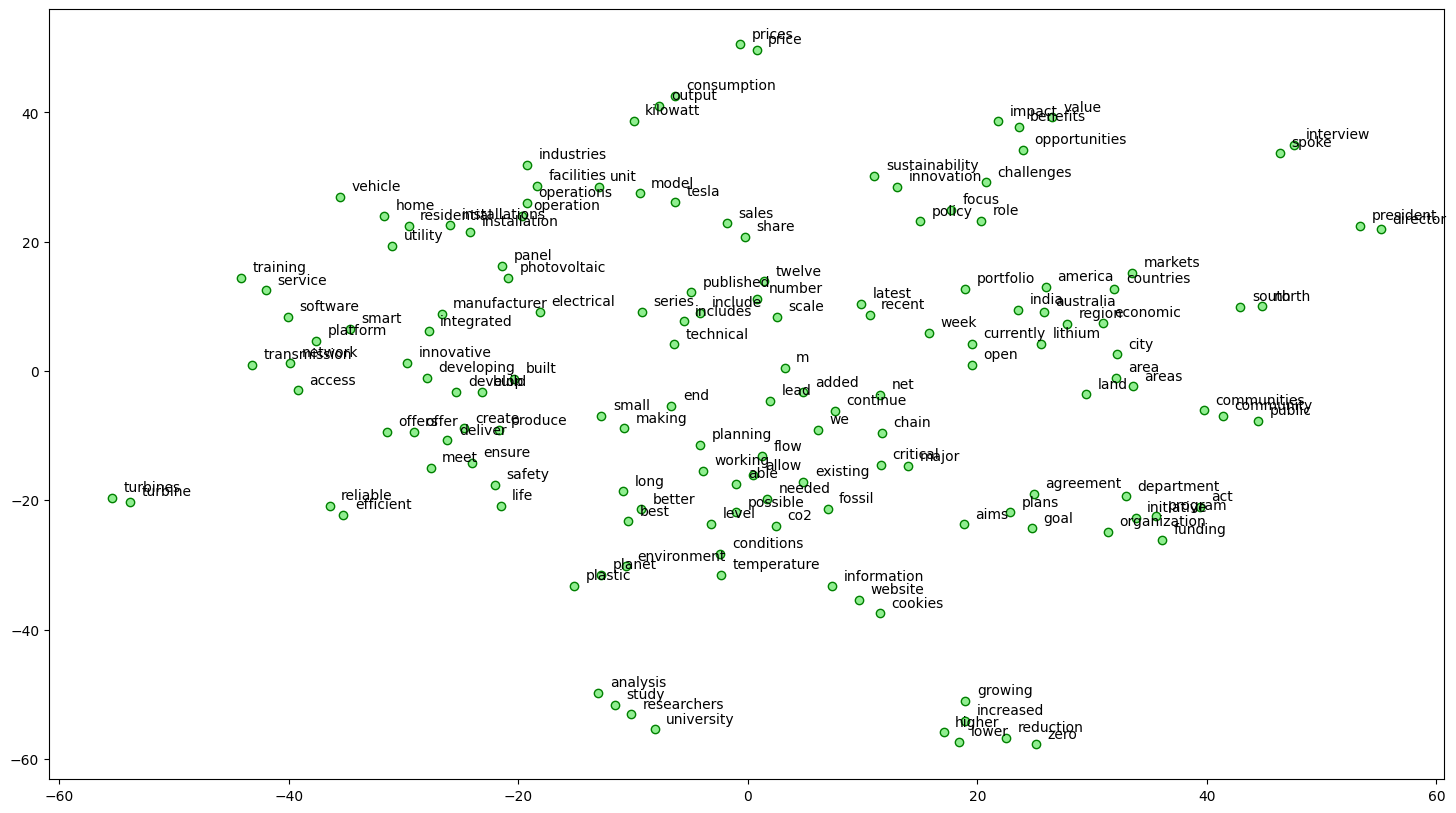

In [ ]:
words = w2vmodel_media.wv.index_to_key[200:350]      # get the word forms of voculary sample
wvs = w2vmodel_media.wv[words]                     # get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

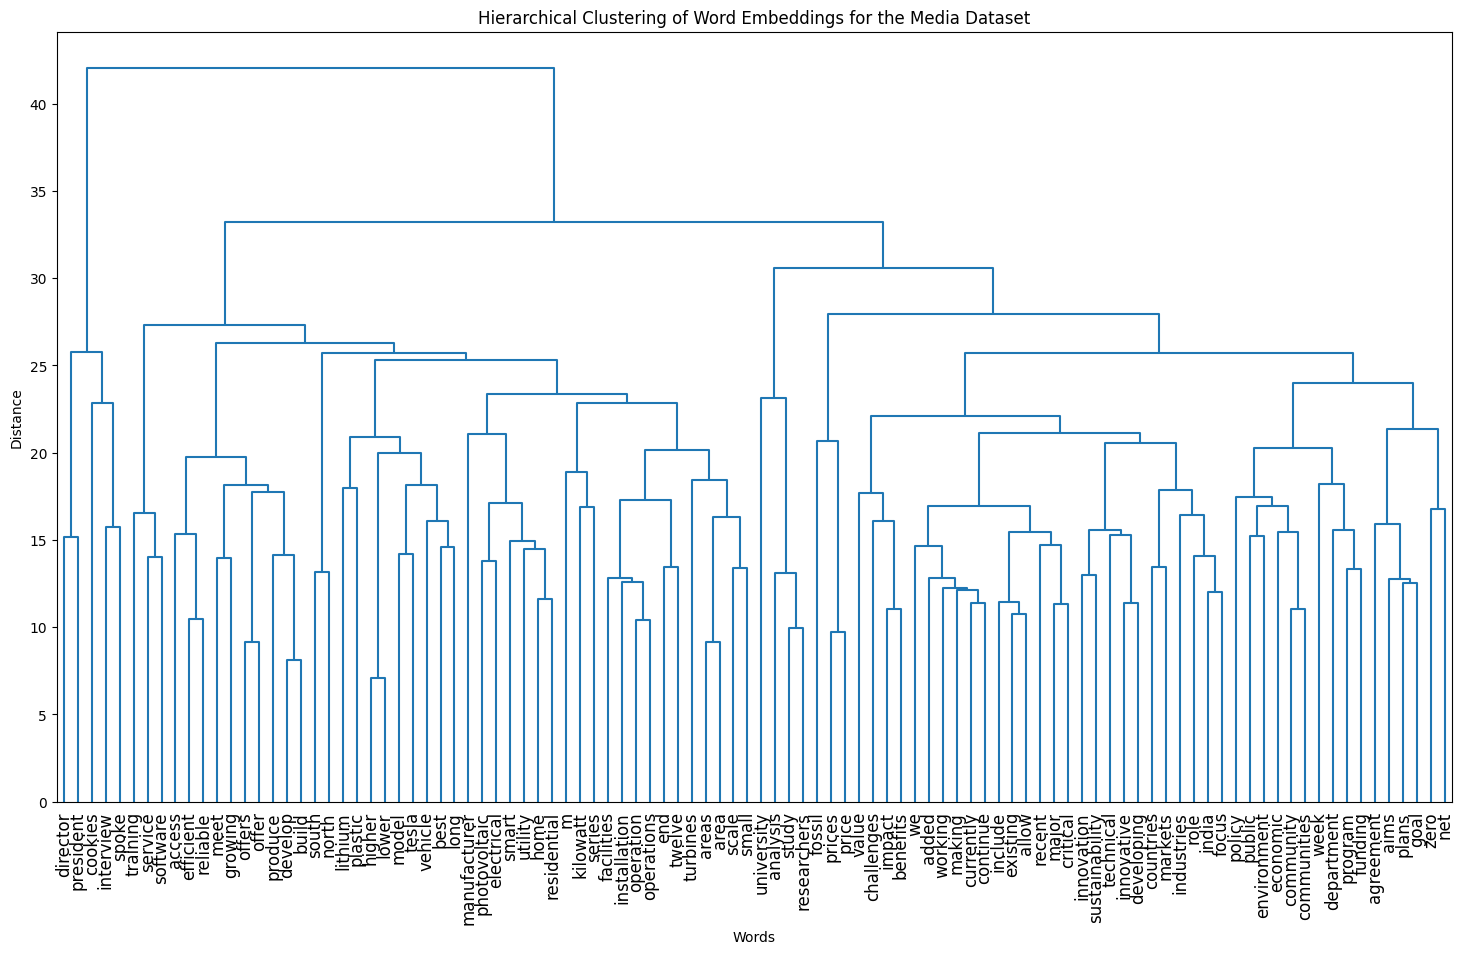

In [ ]:
# Hierarchical Clustering

words = w2vmodel_media.wv.index_to_key[200:300]  # Get a subset of words from the vocabulary
wvs = np.array([w2vmodel_media.wv[word] for word in words])  # Get the word vectors for these words

# Perform Hierarchical Clustering
Z = linkage(wvs, 'ward')  # Using 'ward' method for linkage (you can change this to other methods like 'single', 'complete', etc.)

# Plotting the Dendrogram
plt.figure(figsize=(18, 10))
dendrogram(Z, labels=words, leaf_rotation=90, leaf_font_size=12, color_threshold=0.7)
plt.title("Hierarchical Clustering of Word Embeddings for the Media Dataset")
plt.xlabel("Words")
plt.ylabel("Distance")
plt.show()


### 2.1.2 Patent Dataset

In [ ]:
print(patent_train['tokens'].head())

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      [organic, photovoltaic, cells, opvs, compositions, described, embodiments, acceptor, active, layer, opv, includes, nonfullerene, acceptor, nonfullerene, acceptors, provide, improved, opv, performance, characteristics, improved, power, conversion, efficiency, open, circuit, voltage, factor, short, circuit, current, andor, external, quantum, efficiency]
1                                                                                                                              

In [ ]:
# Hyperparameter grid
feature_sizes = [100, 200, 300]
window_sizes = [3, 5, 7]
min_word_counts = [1, 5, 10]

# Store the best model and its evaluation score
best_score = -np.inf
best_params = None
best_model = None

# Loop over hyperparameters
for feature_size in feature_sizes:
    for window_size in window_sizes:
        for min_word_count in min_word_counts:
            # Train the model with the current set of hyperparameters
            w2v_model_patent = Word2Vec(sentences=patent_train['tokens'],
                                  vector_size=feature_size,
                                  window=window_size,
                                  min_count=min_word_count,
                                  sg=0)  # Skip-gram (set to 0 for CBOW)

            # Evaluate model: Here we can use word similarity as an example
            word_pairs = [
                ('king', 'queen'),
                ('man', 'woman'),
                ('blue', 'red'),
                ('apple', 'orange')
            ]

            similarity_score = 0
            for word1, word2 in word_pairs:
                if word1 in w2v_model_patent.wv and word2 in w2v_model_patent.wv:
                    # Calculate cosine similarity between word vectors
                    similarity = cosine_similarity([w2v_model_patent.wv[word1]], [w2v_model_patent.wv[word2]])[0][0]
                    similarity_score += similarity

            # If the current model performs better, save it
            if similarity_score > best_score:
                best_score = similarity_score
                best_params = (feature_size, window_size, min_word_count)
                best_model = w2v_model_patent

# Print the best hyperparameters
print(f"Best Hyperparameters: feature_size={best_params[0]}, window_size={best_params[1]}, min_word_count={best_params[2]}")
print(f"Best Similarity Score: {best_score}")

Best Hyperparameters: feature_size=100, window_size=5, min_word_count=1
Best Similarity Score: 1.5315741300582886


In [ ]:
# w2v model for patent dataset
feature_size = 100  # Word vector dimensionality
window_context = 5  # Context window size
min_word_count = 1  # Minimum word count

w2vmodel_patent = Word2Vec(sentences= patent_train['tokens'], vector_size=feature_size, window=window_context, min_count=min_word_count, sg = 0)

In [ ]:
# View all the words in the vocabulary
vocab = list(w2vmodel_patent.wv.index_to_key)
print(vocab[:10])  # Print the first 10 words in the vocabulary


['energy', 'solar', 'power', 'water', 'heat', 'device', 'arranged', 'comprises', 'connected', 'storage']


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


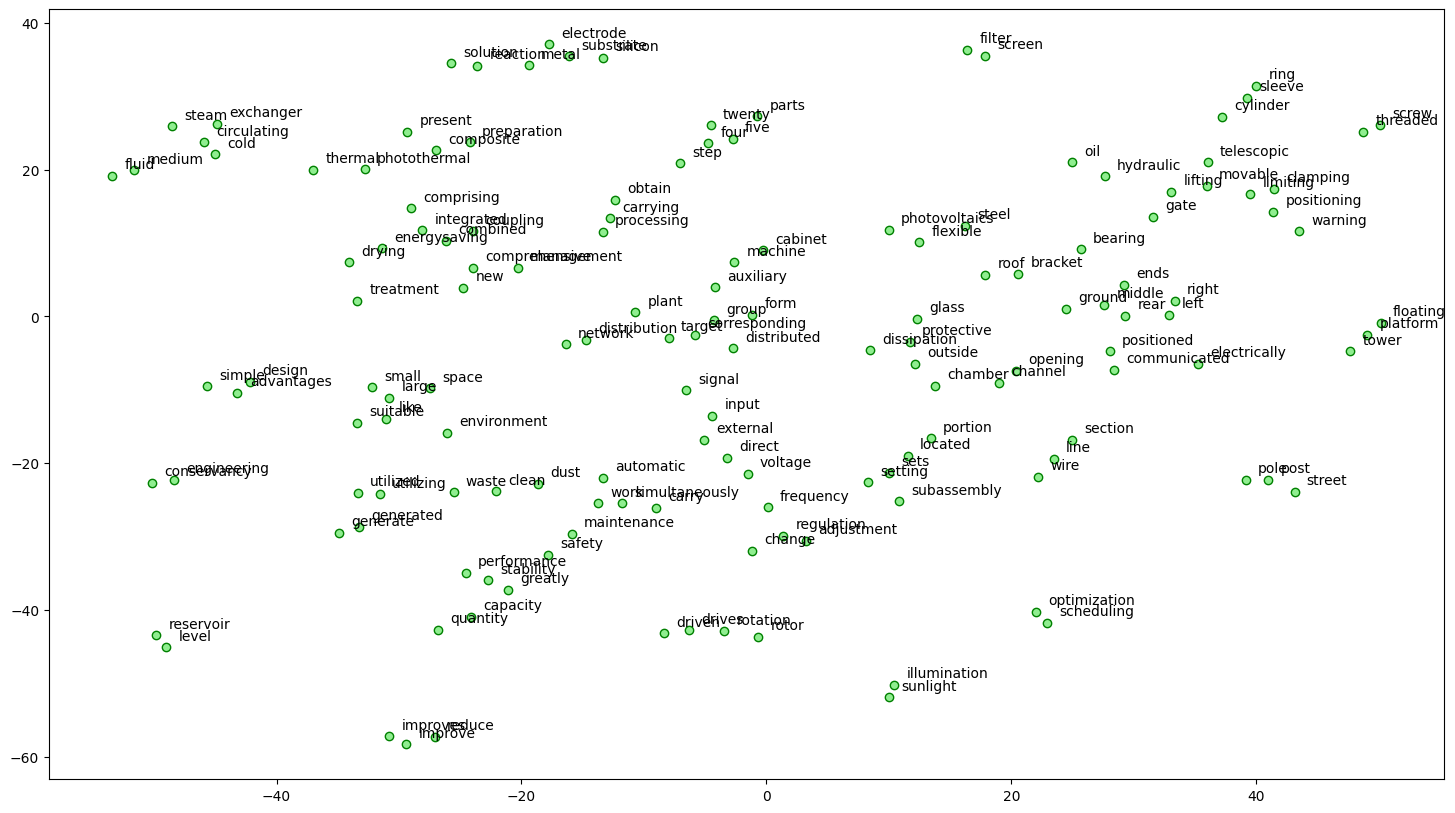

In [ ]:
words = w2vmodel_patent.wv.index_to_key[200:350]      ## get the word forms of voculary sample
wvs = w2vmodel_patent.wv[words]                     ## get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

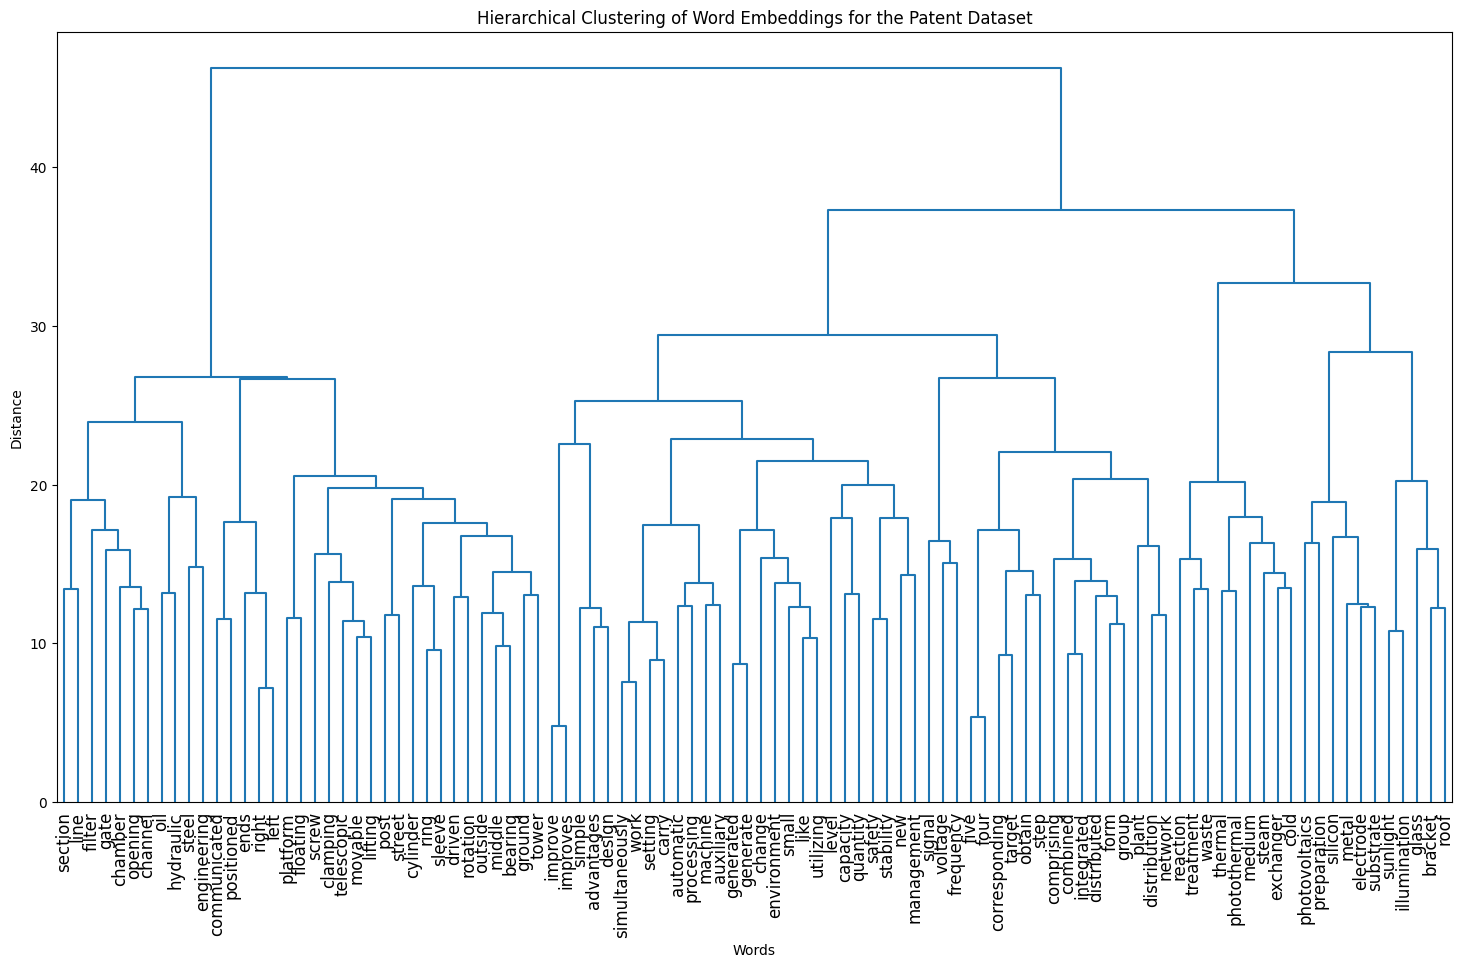

In [ ]:
# Hierarchical Clustering

words = w2vmodel_patent.wv.index_to_key[200:300]  # Get a subset of words from the vocabulary
wvs = np.array([w2vmodel_patent.wv[word] for word in words])  # Get the word vectors for these words

# Perform Hierarchical Clustering
Z = linkage(wvs, 'ward')  # Using 'ward' method for linkage (you can change this to other methods like 'single', 'complete', etc.)

# Plotting the Dendrogram
plt.figure(figsize=(18, 10))
dendrogram(Z, labels=words, leaf_rotation=90, leaf_font_size=12, color_threshold=0.7)
plt.title("Hierarchical Clustering of Word Embeddings for the Patent Dataset")
plt.xlabel("Words")
plt.ylabel("Distance")
plt.show()


### 2.1.3 Comparison of Media and Patent Dataset

In [ ]:
# Compare similiraty between the two models


# Get embeddings for words in common
common_words = list(set(w2vmodel_patent.wv.index_to_key).intersection(set(w2vmodel_media.wv.index_to_key)))

# Extract vectors for common words
patent_vectors = np.array([w2vmodel_patent.wv[word] for word in common_words])
media_vectors = np.array([w2vmodel_media.wv[word] for word in common_words])

# Calculate cosine similarities
similarities = cosine_similarity(patent_vectors, media_vectors)

# Display the similarities for the first 10 common words
for word, similarity in zip(common_words[:10], similarities[:10]):
    print(f"Word: {word} | Cosine Similarity: {similarity[0]:.4f}")

Word: authority | Cosine Similarity: 0.1683
Word: cyano | Cosine Similarity: 0.1970
Word: piles | Cosine Similarity: -0.1091
Word: lowcost | Cosine Similarity: 0.2904
Word: prejudging | Cosine Similarity: 0.2945
Word: pickup | Cosine Similarity: 0.1308
Word: best | Cosine Similarity: 0.1686
Word: lake | Cosine Similarity: 0.0154
Word: modification | Cosine Similarity: 0.1826
Word: depth | Cosine Similarity: 0.0260


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


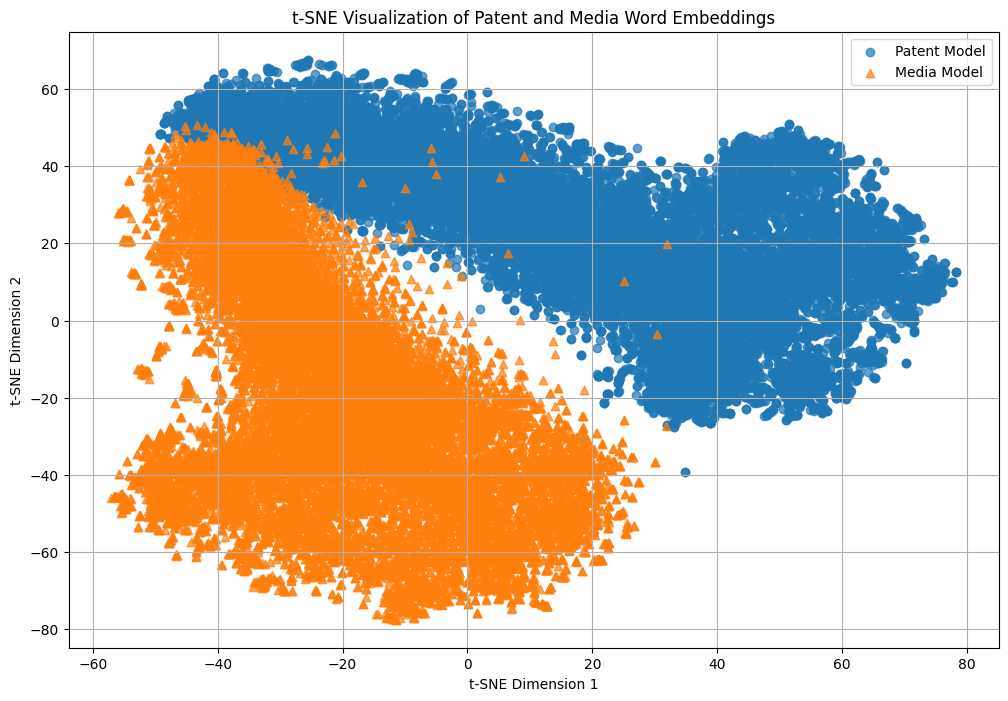

In [ ]:
# Combine vectors for visualization
combined_vectors = np.concatenate((patent_vectors, media_vectors), axis=0)

# Perform t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(combined_vectors)

# Split back into patent and media vectors
n = len(patent_vectors)
tsne_patent = tsne_results[:n]
tsne_media = tsne_results[n:]

# Plot the results
plt.figure(figsize=(12, 8))
plt.scatter(tsne_patent[:, 0], tsne_patent[:, 1], label='Patent Model', alpha=0.7, marker='o')
plt.scatter(tsne_media[:, 0], tsne_media[:, 1], label='Media Model', alpha=0.7, marker='^')
plt.legend()
plt.title("t-SNE Visualization of Patent and Media Word Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid()
plt.show()

The two clusters of points (patent: blue and media: orange) are relatively distinct, with minimal overlap. This indicates that the Patent Model and Media Model represent word meanings in different ways.

There is a small region of overlap in the middle where the media and patent points mix.

However we can say that due to the clusters being tightly packed within their respective models, both models exhibit internal consistency.

In [ ]:
# Identifying the common words
media_words = w2vmodel_media.wv[word]
patent_words = w2vmodel_patent.wv[word]

patent_set = set(patent_words)
media_set = set(media_words)

common_words = list(patent_set.intersection(media_set))

# Frequency of common words
all_word_frequencies = Counter(patent_words + media_words)  # Example combined word counts

# Step 3: Sort words by frequency
common_word_frequencies = {word: all_word_frequencies[word] for word in common_words}
sorted_common_words = sorted(common_word_frequencies.items(), key=lambda x: x[1], reverse=True)

# Step 4: Return or display the results
print("Top Common Words by Frequency:")
for word, freq in sorted_common_words[:10]:  # Top 10
    print(f"{word}: {freq}")

print(f"Patent Words: {len(patent_words)} words")
print(f"Media Words: {len(media_words)} words")
print(f"Common Words: {len(common_words)} words")


Top Common Words by Frequency:
Patent Words: 100 words
Media Words: 100 words
Common Words: 0 words


Looking at the snipped now, we see that there are no common words found. However it is important to note that we have run the analysis on a very small data snippet due to the best fit model.

### 4. Transfer Learning with Advanced Open-Source Models

### 4.4 FLAN-T5

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base", device_map="auto")


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# Define the function to generate text
def flan_t5(input_text, max_new_tokens=50):
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True)
    outputs = model.generate(**inputs, max_new_tokens=max_new_tokens)
    result = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return [{"generated_text": result}]

### 4.4.1. Media Dataset

In [ ]:
def apply_flan_t5(df_tokens, max_len=512, overlap=50, max_new_tokens=50):
    results = []
    for i in range(0, len(df_tokens), max_len - overlap):
        chunk = df_tokens[i:i + max_len]
        chunk_text = " ".join(chunk)  # Convert tokens to text if required
        result = flan_t5(chunk_text, max_new_tokens=max_new_tokens)  # Specify max_new_tokens
        results.append(result[0]['generated_text'])
    return " ".join(results)


In [ ]:
# subset dataset to make the model run
media_train_subset = media_train.sample(n=100, random_state=42)

# Apply with custom generation length
media_train['flan_t5_output'] = media_train['tokens'].apply(apply_flan_t5)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
# Visualisation

sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# FLAN-T5 outputs into embeddings
flan_sentences_media = media_train['flan_t5_output'].dropna().tolist()  # Remove NaNs
flan_embeddings_media = sentence_model.encode(flan_sentences_media)  # Get embeddings

# Use t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=3000)
flan_tsne = tsne.fit_transform(flan_embeddings_media)

# Plotting
plt.figure(figsize=(12, 8))
plt.scatter(flan_tsne[:, 0], flan_tsne[:, 1], c='skyblue', edgecolors='b')

plt.title("t-SNE Visualization of FLAN-T5 Media Outputs")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

The google collab and google collab pro has not been able to run the model code and kept disconnecting the runtime no matter the size of the model. For completion and to show the work put in we leave the code in. Same applies for the patent dataset.

### 4.4.2. Patent Dataset

In [ ]:
# subset dataset to make the model run
patent_train_subset = patent_train.sample(n=100, random_state=42)

patent_train['flan_t5_output'] = patent_train['tokens'].apply(apply_flan_t5)

In [ ]:
# Visualisation

sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# FLAN-T5 outputs into embeddings
flan_sentences_patent = patent_train['flan_t5_output'].dropna().tolist()  # Remove NaNs
flan_embeddings_patent = sentence_model.encode(flan_sentences_patent)  # Get embeddings

# Use t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=3000)
flan_tsne = tsne.fit_transform(flan_embeddings_patent)

# Plotting
plt.figure(figsize=(12, 8))
plt.scatter(flan_tsne[:, 0], flan_tsne[:, 1], c='skyblue', edgecolors='b')

plt.title("t-SNE Visualization of FLAN-T5 Patent Outputs")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

### 4.5. BART

In [ ]:
# Make sure that GPU is being used (if relevant)
import torch
from transformers import BartForConditionalGeneration, BartTokenizer

# Check if a GPU is available and set the device accordingly
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("GPU is available and being used.")
else:
  device = torch.device("cpu")
  print("GPU not found, using CPU instead.")

# Load the BART model and tokenizer, moving them to the selected device
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large", forced_bos_token_id=0).to(device)
bart_tok = BartTokenizer.from_pretrained("facebook/bart-large")

GPU is available and being used.


In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer

bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-base", forced_bos_token_id=0)
bart_tok = BartTokenizer.from_pretrained("facebook/bart-base")

### 4.5.1. Media Dataset

In [ ]:
def apply_bart_generation(text, max_length=50):
    # Join the tokens back into a string
    text = " ".join(text)
    # Tokenize the input text with bart
    inputs = bart_tok(text, return_tensors="pt", truncation=True, max_length=512).to(device)

    # Generate output from the model
    outputs = bart_model.generate(
        inputs['input_ids'],
        max_length=max_length,
        num_beams=5,  # Beam search for better quality
        early_stopping=True
    )

    # Decode the generated text
    generated_text = bart_tok.decode(outputs[0], skip_special_tokens=True)
    return generated_text


KeyboardInterrupt: 

In [ ]:
media_train['bart_output'] = media_train_subset['tokens'].apply(lambda x: apply_bart_generation(x))

# Display the updated DataFrame
import ace_tools as tools; tools.display_dataframe_to_user(name="BART Model Output", dataframe=media_train_subset)
print(media_train.head())

In [ ]:
def apply_bart_generation(text, max_length=50):
    # Tokenize the input text with bart
    inputs = bart_tok(text, return_tensors="pt", truncation=True, max_length=512)

    # Generate output from the model
    outputs = bart_model.generate(
        inputs['input_ids'],
        max_length=max_length,
        num_beams=5,  # Beam search for better quality
        early_stopping=True
    )

    # Decode the generated text
    generated_text = bart_tok.decode(outputs[0], skip_special_tokens=True)
    return generated_text

media_train['bart_output'] = media_train['tokens'].apply(lambda x: apply_bart_generation(x))

# Display the updated DataFrame
import ace_tools as tools; tools.display_dataframe_to_user(name="BART Model Output", dataframe=media_train)
print(media_train.head())

ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`input_ids` in this case) have excessive nesting (inputs type `list` where type `int` is expected).

In [ ]:
# Word Cloud
all_bart_media = " ".join(media_train['bart_output'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_bart_media)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of BART Outputs")
plt.show()

### 4.5.2. Patent Dataset

In [ ]:
patent_train['bart_output'] = patent_train['tokens'].apply(lambda x: apply_bart_generation(x))

print(patent_train.head())

In [ ]:
# Word Cloud
all_bart_media = " ".join(media_train['bart_output'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_bart_media)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of BART Outputs")
plt.show()

Has with Bart simmilar issues as to Flan-T5. In the end we could not make it run after trying various trouble shooting mechanisms. We still decided to leave the code in as a testimony of our attemps.